In [1]:
# Import dependencies
import os

ModuleNotFoundError: No module named 'findspark'

In [2]:
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install pyspark==3.5.1
!pip install -q findspark
!pip install scikit-learn
!pip install hvplot holoviews

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,084 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,858 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [47.6 kB]
Get:13 http

In [3]:
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark import pandas as ps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hvplot.pandas
import holoviews as hv
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
# Start a SparkSession
findspark.init()

In [5]:
 # Start Spark session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [6]:
 # Read in data from S3 Buckets
url ="https://realestateproj.s3.ap-southeast-2.amazonaws.com/real-estate-sales.csv"

spark.sparkContext.addFile(url)

df_spark = spark.read.csv(SparkFiles.get("real-estate-sales.csv"), header=True, inferSchema=True)
# https://docs.databricks.com/en/pandas/pyspark-pandas-conversion.html#:~:text=Series%20.-,Convert%20PySpark%20DataFrames%20to%20and%20from%20pandas%20DataFrames,DataFrame%20with%20createDataFrame(pandas_df)%20.
df = df_spark.select("*").toPandas()

# Show DataFrame
df.head(10)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,None,None,None,None,None
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,None,None,None,None
2,210317,2021,07/05/2022,Avon,53 COTSWOLD WAY,329730.0,805000.0,0.4096,Residential,Single Family,None,None,None,POINT (-72.846365959 41.781677018)
3,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,None,None,None,None
4,200243,2020,04/13/2021,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,None,None,None,None
5,200377,2020,07/02/2021,Avon,70 FAR HILLS DRIVE,862330.0,1447500.0,0.5957,Residential,Single Family,None,None,None,None
6,200109,2020,12/09/2020,Avon,57 FAR HILLS DRIVE,847520.0,1250000.0,0.6780,Residential,Single Family,None,None,None,None
7,2020180,2020,03/01/2021,Berlin,1539 FARMINGTON AVE,234200.0,130000.0,1.8015,Residential,Two Family,08 - Part Interest,None,None,None
8,2020313,2020,07/01/2021,Berlin,216 WATCH HILL RD,412000.0,677500.0,0.6081,Residential,Single Family,None,None,None,None
9,200097,2020,06/04/2021,Bethany,23 AMITY RD,511000.0,795000.0,0.6427,Commercial,None,None,None,None,None


In [7]:
# get column names
df.columns

Index(['Serial Number', 'List Year', 'Date Recorded', 'Town', 'Address',
       'Assessed Value', 'Sale Amount', 'Sales Ratio', 'Property Type',
       'Residential Type', 'Non Use Code', 'Assessor Remarks', 'OPM remarks',
       'Location'],
      dtype='object')

In [8]:
# drop columns that are unneeded
# df_dropped = df.drop(columns=['Serial Number', 'Assessor Remarks', "OPM remarks",'Location','Non Use Code'])
df_linreg = df[['Town','Sale Amount','Assessed Value','Date Recorded','Sales Ratio']]
df_linreg.head(10)

,Town,Sale Amount,Assessed Value,Date Recorded,Sales Ratio
0,Ansonia,325000.0,150500.0,09/13/2021,0.4630
1,Ashford,430000.0,253000.0,10/02/2020,0.5883
2,Avon,805000.0,329730.0,07/05/2022,0.4096
3,Avon,179900.0,130400.0,03/09/2021,0.7248
4,Avon,890000.0,619290.0,04/13/2021,0.6958
5,Avon,1447500.0,862330.0,07/02/2021,0.5957
6,Avon,1250000.0,847520.0,12/09/2020,0.6780
7,Berlin,130000.0,234200.0,03/01/2021,1.8015
8,Berlin,677500.0,412000.0,07/01/2021,0.6081
9,Bethany,795000.0,511000.0,06/04/2021,0.6427


In [9]:
# check data types
df_linreg.dtypes

Town               object
Sale Amount       float64
Assessed Value    float64
Date Recorded      object
Sales Ratio       float64
dtype: object

In [10]:
df_linreg['Date Recorded'] = pd.to_datetime(df_linreg['Date Recorded'], format='%m/%d/%Y')

<ipython-input-10-958f684fd199>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linreg['Date Recorded'] = pd.to_datetime(df_linreg['Date Recorded'], format='%m/%d/%Y')


In [11]:
df_linreg.dtypes

Town                      object
Sale Amount              float64
Assessed Value           float64
Date Recorded     datetime64[ns]
Sales Ratio              float64
dtype: object

In [12]:
df_linreg.head()

,Town,Sale Amount,Assessed Value,Date Recorded,Sales Ratio
0,Ansonia,325000.0,150500.0,2021-09-13,0.4630
1,Ashford,430000.0,253000.0,2020-10-02,0.5883
2,Avon,805000.0,329730.0,2022-07-05,0.4096
3,Avon,179900.0,130400.0,2021-03-09,0.7248
4,Avon,890000.0,619290.0,2021-04-13,0.6958


In [13]:
# check DataFrame
df_linreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054159 entries, 0 to 1054158
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Town            1054159 non-null  object        
 1   Sale Amount     1054158 non-null  float64       
 2   Assessed Value  1054158 non-null  float64       
 3   Date Recorded   1054157 non-null  datetime64[ns]
 4   Sales Ratio     1054158 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 40.2+ MB


In [14]:
df_linreg.dropna(inplace=True)

<ipython-input-14-a39592b3a904>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linreg.dropna(inplace=True)


In [15]:
# check DataFrame info again
df_linreg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1054156 entries, 0 to 1054158
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Town            1054156 non-null  object        
 1   Sale Amount     1054156 non-null  float64       
 2   Assessed Value  1054156 non-null  float64       
 3   Date Recorded   1054156 non-null  datetime64[ns]
 4   Sales Ratio     1054156 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 48.3+ MB


In [16]:
# check DataFrame summary stats again
df_linreg.describe()

,Sale Amount,Assessed Value,Date Recorded,Sales Ratio
count,1.054156e+06,1.054156e+06,1054156,1.054156e+06
mean,3.990294e+05,2.797421e+05,2012-01-18 05:13:09.792782080,9.953269e+00
min,0.000000e+00,0.000000e+00,1999-04-05 00:00:00,0.000000e+00
25%,1.422000e+05,8.845000e+04,2005-09-16 00:00:00,4.816010e-01
50%,2.300000e+05,1.395800e+05,2011-12-02 00:00:00,6.162891e-01
75%,3.700000e+05,2.270000e+05,2018-02-14 00:00:00,7.764000e-01
max,5.000000e+09,8.815100e+08,2022-09-30 00:00:00,1.226420e+06
std,5.229766e+06,1.650120e+06,NaN,1.838436e+03


Linear regression model

In [17]:
#https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
q = df["Sale Amount"].quantile(0.99)
df_linreg[df_linreg["Sale Amount"] < q]
q_low = df_linreg["Sale Amount"].quantile(0.01)
q_hi  = df_linreg["Sale Amount"].quantile(0.99)

df_filtered1 = df_linreg[(df_linreg["Sale Amount"] < q_hi)]
df_filtered1.sort_values(by='Sale Amount', ascending=False).head(10)

,Town,Sale Amount,Assessed Value,Date Recorded,Sales Ratio
86426,Fairfield,2899000.0,872130.0,2022-03-08,0.300800
85426,Fairfield,2899000.0,663670.0,2021-12-03,0.228900
970847,Greenwich,2899000.0,2095660.0,2018-12-14,0.722891
479921,Greenwich,2899000.0,2624790.0,2007-04-17,0.905412
1023551,New Canaan,2898350.0,2240000.0,2020-05-20,0.772900
36953,New Canaan,2898000.0,1585220.0,2021-08-02,0.547000
651321,Westport,2895868.0,506300.0,2012-07-11,0.174835
762847,Greenwich,2895500.0,1854580.0,2014-12-03,0.640504
20864,Greenwich,2895000.0,2088100.0,2020-12-02,0.721200
866439,Darien,2895000.0,1934310.0,2017-03-17,0.668155


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
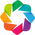

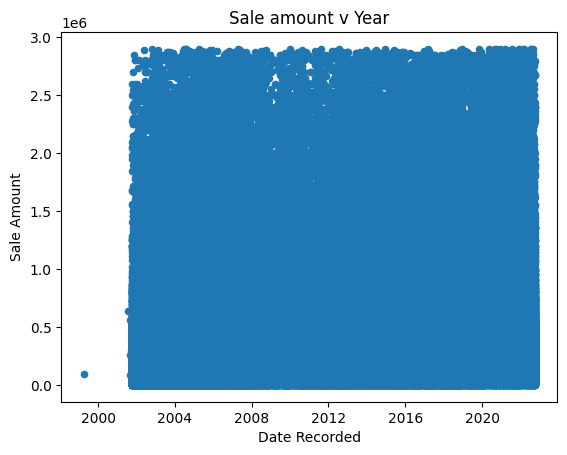

In [22]:
hv.extension('bokeh')
# plot sale amount vs Year

df_filtered1.plot.scatter(x='Date Recorded', y='Sale Amount',title="Sale amount v Year");

In [23]:
q = df_filtered1["Assessed Value"].quantile(0.99)
df_filtered1[df_filtered1["Assessed Value"] < q]
q_low = df_filtered1["Assessed Value"].quantile(0.01)
q_hi  = df_filtered1["Assessed Value"].quantile(0.99)

df_filtered = df_filtered1[(df_filtered1["Assessed Value"] < q_hi)]
df_filtered.sort_values(by='Assessed Value', ascending=False).head(10)

,Town,Sale Amount,Assessed Value,Date Recorded,Sales Ratio
77283,New Canaan,2399000.0,1465590.0,2022-01-21,0.610900
256267,Fairfield,2250000.0,1465520.0,2003-12-17,0.651342
949993,East Hartford,2683000.0,1465460.0,2019-07-18,0.546202
988174,West Haven,876040.0,1465450.0,2019-09-03,1.672800
413619,Norwalk,2200000.0,1465450.0,2005-10-07,0.666114
647816,New Canaan,1699000.0,1465380.0,2011-08-22,0.862496
626279,Darien,1850000.0,1465310.0,2011-03-02,0.792059
800861,Westport,2805000.0,1465251.0,2015-04-09,0.522371
360453,New Canaan,2860000.0,1465100.0,2004-12-21,0.512273
808122,New Canaan,1900000.0,1465030.0,2016-05-13,0.771068


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
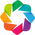

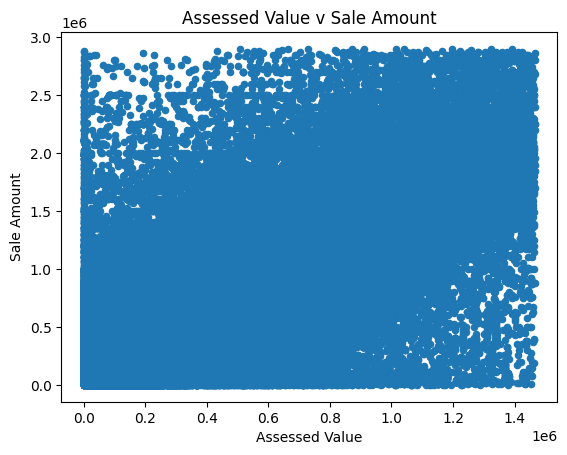

In [24]:
hv.extension('bokeh')
# plot sale amount vs assessed value

df_filtered.plot.scatter(x='Assessed Value', y='Sale Amount',title="Assessed Value v Sale Amount");

In [25]:
# Reformat data of the independent variable X as a single-column array
X = df_filtered["Assessed Value"].values.reshape(-1, 1)
X = X.astype(np.float64)
# Display sample data
X[:5]

array([[150500.],
       [253000.],
       [329730.],
       [130400.],
       [619290.]])

In [26]:
X.shape

(1033085, 1)

In [27]:
y = df_filtered["Sale Amount"]

In [28]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

In [29]:
 # Fit the data into the model
model.fit(X, y)

LinearRegression()

In [30]:
 # Display the slope
print(f"Model's slope: {model.coef_}")

Model's slope: [1.36256677]


In [31]:
# Display the y-intercept
print(f"Model's y-intercept: {model.intercept_}")

Model's y-intercept: 50755.17471295784


In [32]:
 # Display the model's best fit line formula
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]}X")

Model's formula: y = 50755.17471295784 + 1.3625667664027232X


In [33]:
# Make predictions using the X set
predicted_y_values = model.predict(X)

In [ ]:
# evaluate the model
score = model.score(X, y, sample_weight=None)
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

In [35]:
# Create a copy of the original data
df_sale_amt_pred = df_filtered.copy()

# Add a column with the predicted salary values
df_sale_amt_pred["Sale Amount"] = predicted_y_values

# Display sample data
df_sale_amt_pred.head(10)

,Town,Sale Amount,Assessed Value,Date Recorded,Sales Ratio
0,Ansonia,2.558215e+05,150500.0,2021-09-13,0.4630
1,Ashford,3.954846e+05,253000.0,2020-10-02,0.5883
2,Avon,5.000343e+05,329730.0,2022-07-05,0.4096
3,Avon,2.284339e+05,130400.0,2021-03-09,0.7248
4,Avon,8.945791e+05,619290.0,2021-04-13,0.6958
5,Avon,1.225737e+06,862330.0,2021-07-02,0.5957
6,Avon,1.205558e+06,847520.0,2020-12-09,0.6780
7,Berlin,3.698683e+05,234200.0,2021-03-01,1.8015
8,Berlin,6.121327e+05,412000.0,2021-07-01,0.6081
9,Bethany,7.470268e+05,511000.0,2021-06-04,0.6427


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
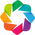

<Axes: xlabel='Assessed Value'>

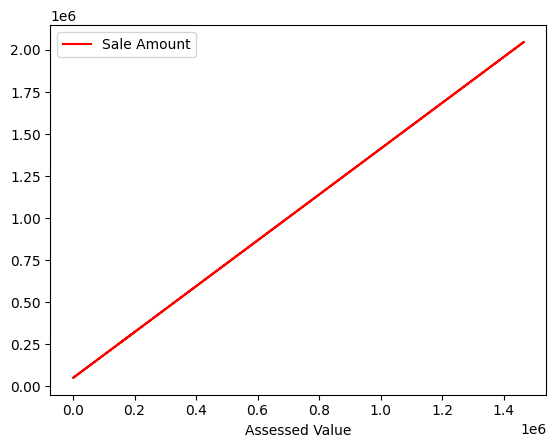

In [36]:
# Create a line plot of years_experience versus the predicted salary values
hv.extension('bokeh')
best_fit_line = df_sale_amt_pred.plot.line(
    x = "Assessed Value",
    y = "Sale Amount",
    color = "red"
)
best_fit_line

TypeError: can't multiply sequence by non-int of type 'Scatter'

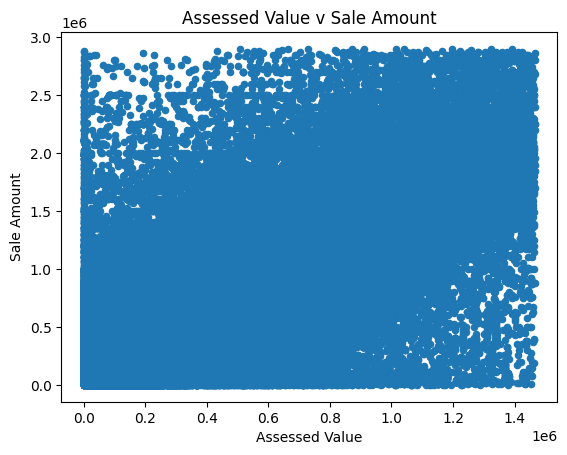

In [39]:
# Superpose the original data and the best fit line
df_filtered.plot.scatter(x='Assessed Value', y='Sale Amount',title="Assessed Value v Sale Amount");

# Plot the line
best_fit_line.plot()

# Create a new DataFrame with the line data
# df_filtered_line = df_filtered.copy()
# df_filtered_line["Line"] = best_fit_line.()

# # Plot the new DataFrame
# df_filtered_line.plot(x="Assessed Value", y=["Sale Amount", "Line"])

# combined_plot = df_filtered.hvplot.scatter(x="Assessed Value", y="Sale Amount") * best_fit_line.plot
# combined_plot